In [104]:
import numpy as np

# Adapted from GalacticBinaryWaveform.c
TSUN = 4.9255e-6
M_PI = 3.14159265358979323846
CLIGHT = 299792458.
PC = 3.0856775815e16
M_PI = np.pi

def galactic_binary_Mc(f, fd):
    pi83 = 21.170591578193 #pow(pi,8./3.)
    return ((fd/(96./5.)/pi83/(f**(11.0/3.0))) ** (3.0/5.0) )/TSUN

def galactic_binary_dL(f, fd, amp):
    return ((5./48.)*(fd/(M_PI*M_PI*f*f*f*amp))*CLIGHT/PC);

def galactic_binary_fdot(Mc, f):
    M = Mc*TSUN
    Q = 19.2 # 96./5.
    return Q*(((M_PI**8)*(M**5)*(f**11))**(1./3.))

def galactic_binary_Amp(Mc, f, D):
    M = Mc*TSUN
    dL= D*PC/CLIGHT
    return 2.*(M**5*(M_PI*f)**2)**(1./3.)/dL

def galactic_binary_dL_from_Mc(f, A, Mc):
    M = Mc * TSUN
    return 2.0*(CLIGHT/PC)*(M**5*(M_PI*f)**2)**(1./3.)/A

#Key points for when you get back to this:
# - The ultimate goal is to write the volume prior bounding volume calc from inside C
#   Therefore you need to pick an analytic SNR approximation that is available in c
# - _FF means fractional frequency
# - GalacticBinaryMatch.c:125 has a link between noise model noise->SnA and 
#   AEnoise_FF/GBnoise_FF functions, but its not on the critical path for gbmcmc
# - noise model is attached to data via GalacticBinaryGetNoiseModel
#
# Next thing to go for:
#  - Working python code that does what the C code does
#  - Understandable plots of noise curve (or sensitivity)

# Adapted from LISA.c
# Arm length (m)
LARM = 2.5e9
# Photon shot noise power (??)
SPS = 8.321000e-23
# Position noise power when using phase data (??)
SLOC = 2.89e-24
# Accelleration noise power (??)
SACC = 9.000000e-30
# Transfer frequency (hz)
FSTAR = CLIGHT/(2.0*np.pi*LARM)
print(FSTAR)

# draw_signal_amplitude has an SNR calculation based on SnA and etaA in the noise model
# GalacticBinaryProposal.c draw_signal_amplitude
#   double sf = data->sine_f_on_fstar;
#   double sn = model->noise[0]->SnA[n]*model->noise[0]->etaA;
#
#  This is the SNR of an amplitude 1.0 signal
#   double SNR1  = analytic_snr(1, sn, sf, data->sqT);
#  

# from GalacticBinaryData.c GalacticBinaryGetNoiseModel
def SnA(f, T):
    return AEnoise_FF(f) + GBnoise_FF(f, T)

# from LISA.c
def AEnoise_FF(f):
    Spm, Sop = get_noise_levels(f)
    x = f/FSTAR
    cosx = np.cos(x)
    cos2x = np.cos(2*x)
    return 8. * noise_transfer_function(x) * ( 2.*Spm*(3. + 2.*cosx + cos2x) + Sop*(2. + cosx) )

def noise_transfer_function(x):
    return np.sin(x)**2

# from LISA.c
def GBnoise_FF(f,T):
    x = f/FSTAR
    t = 4.*x*x*np.sin(x)*np.sin(x)
    
    Ampl = 1.2826e-44
    alpha = 1.629667
    fr2 = 4.810781e-4
    af1 = -2.235e-1
    bf1 = -2.7040844
    afk = -3.60976122e-1
    bfk = -2.37822436
    fr1 = 10.**(af1*np.log10(T/31457280.) + bf1)
    knee = 10.**(afk*np.log10(T/31457280.) + bfk)
    SG_sense = Ampl * np.exp(-pow(f/fr1,alpha)) * f**(-7./3.) * 0.5 * (1.0 + np.tanh(-(f-knee)/fr2) )
    SGXYZ = t*SG_sense
    SGAE  = 1.5*SGXYZ
    return SGAE

def get_noise_levels(f):
    Spm = 2.5e-48*(1.0 + pow(f/1e-4,-2))/f/f
    Sop = 1.8e-37*(0.5)*(0.5)*f*f

    return(Spm, Sop)

def analytic_snr(A, f, T):
    sqT = np.sqrt(T)
    Sn = SnA(f, T)
    Sf = f/FSTAR
    return 0.5*A*sqT*Sf/np.sqrt(Sn)

def amp_from_snr(SNR, f, T):
    sqT = np.sqrt(T)
    Sn = SnA(f, T)
    Sf = f/FSTAR
    return SNR*np.sqrt(Sn)/(Sf*sqT*0.5)


0.01908538063694777


In [ ]:
# Adapted from https://gitlab.in2p3.fr/LISA/LDC/-/blob/develop/ldc/lisa/noise/noise.py?ref_type=heads



121.87996484714975


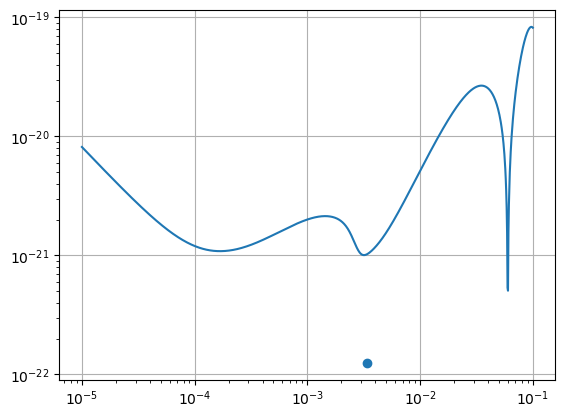

In [124]:
import matplotlib.pyplot as plt

import astropy.units as u
YEAR = u.yr.to(u.s)
# time of observation
Tobs = 4*YEAR

x = np.logspace(-5, -1, num=1000, base=10.0)
#print(x)
#y = np.sqrt(x*Sn(x))
y = np.sqrt(SnA(x, Tobs))
#y = np.sqrt(SnA(x, Tobs))/(0.5*x/FSTAR*np.sqrt(Tobs))

plt.plot(x, y)
plt.xscale('log')
plt.yscale('log')
plt.scatter([3.4e-3],[1.25e-22])
plt.grid()



print(analytic_snr(1.25e-22, 3.4e-3, Tobs))

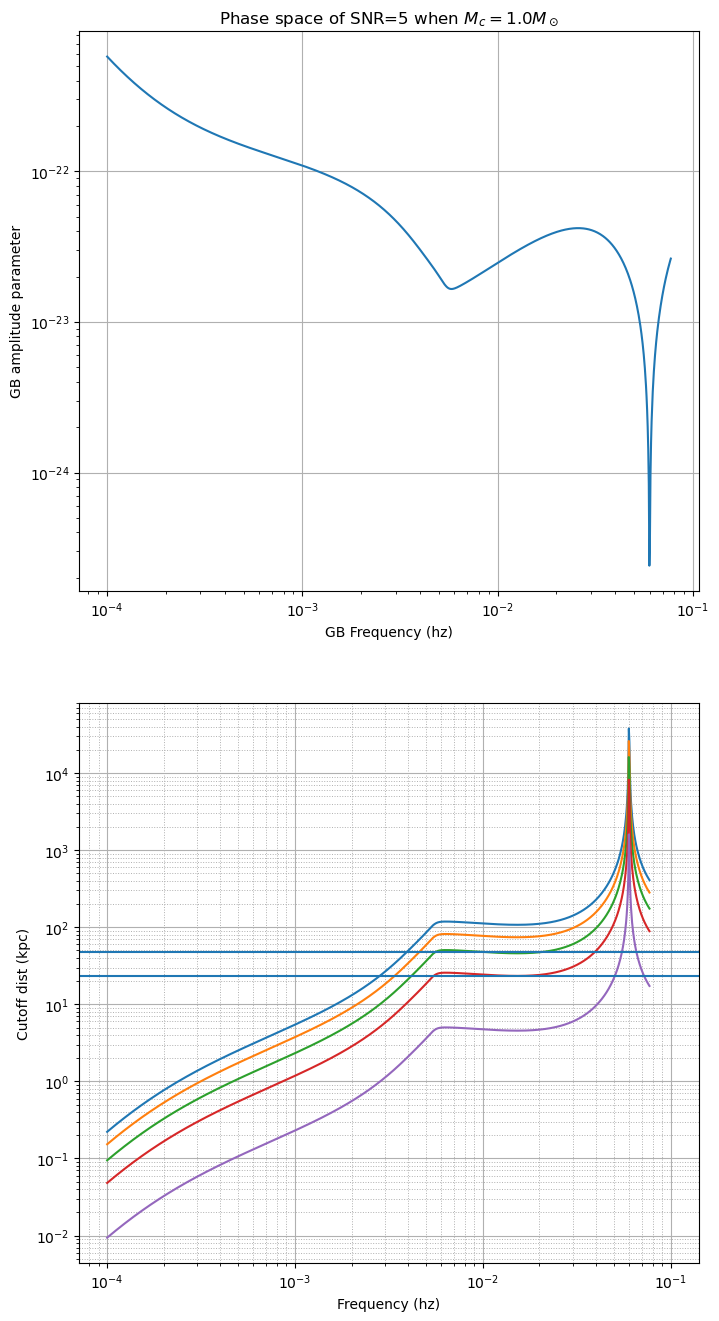

In [141]:
f = np.logspace(-4, np.log10(0.077), num=1000, base=10.0)
m = 1.0 #m_sun
t = 0.5*YEAR
cutoff = 5

def plot_snr_cutoff(cutoff, ax, f, m, t):
    amp = amp_from_snr(cutoff, f, t)
    d = galactic_binary_dL_from_Mc(f, amp, m)/1000
    ax.plot(f, d)

amp = amp_from_snr(cutoff, f, 0.5*YEAR)
#fd = galactic_binary_fdot(m, f)
d = galactic_binary_dL_from_Mc(f, amp, m)

fig, (ax1, ax2) = plt.subplots(2,1)
fig.set_size_inches(8,16)

ax1.plot(f, amp)
ax1.set_title(f"Phase space of SNR={cutoff} when $M_c = 1.0 M_\odot$")
ax1.set_xscale('log')
ax1.set_xlabel("GB Frequency (hz)")
ax1.set_yscale('log')
ax1.set_ylabel("GB amplitude parameter")
ax1.grid()

#plot_snr_cutoff(1, ax2, f, m, t)
plot_snr_cutoff(cutoff, ax2, f, 1.0, t)
plot_snr_cutoff(cutoff, ax2, f, 0.8, t)
plot_snr_cutoff(cutoff, ax2, f, 0.6, t)
plot_snr_cutoff(cutoff, ax2, f, 0.4, t)
plot_snr_cutoff(cutoff, ax2, f, 0.15, t)
#plot_snr_cutoff(50, ax2, f, m, t)
#plot_snr_cutoff(100, ax2, f, m, t)
ax2.grid(which="both")
ax2.grid(which='minor', linestyle=':', linewidth=0.7)
ax2.set_xlabel("Frequency (hz)")
ax2.set_xscale('log')
ax2.set_ylabel("Cutoff dist (kpc)")
ax2.axline((1e-4,23),(1e-1,23))
ax2.axline((1e-4,48),(1e-1,48))
ax2.set_yscale('log')
ax2.minorticks_on()



15.891755239838533
1.2499999999999996e-22


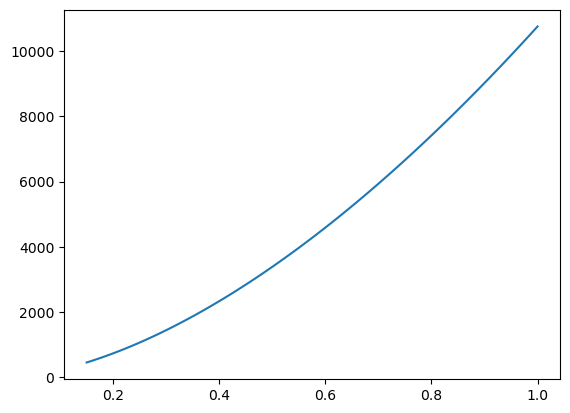

In [128]:
# Fixed frequency, amp. Plot M vs D
f = 3.4e-3
a = 1.25e-22

mc = np.linspace(0.15,1.0,100)
dl = galactic_binary_dL_from_Mc(f, a, mc)

plt.plot(mc,dl)

SNR = analytic_snr(a, f, 0.5*YEAR)
print(SNR)
print(amp_from_snr(SNR, f, 0.5*YEAR))

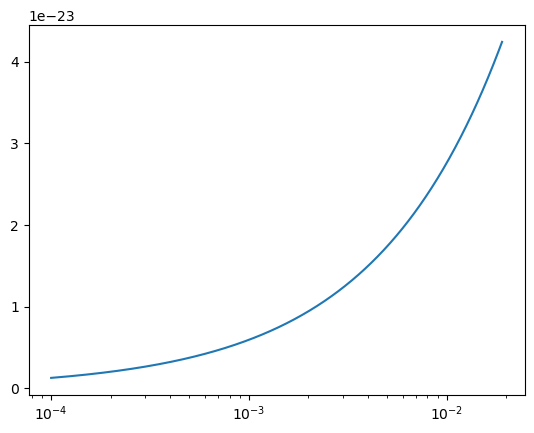

In [130]:
# plot F vs amp for fixed M, D
mc = 1.0
d = 100*1000 # pc

f = np.logspace(-4, np.log10(FSTAR), num=1000, base=10.0)
amp = galactic_binary_Amp(mc,f, d)

plt.plot(f, amp)
plt.xscale('log')

/home/mtauraso/src/ldasoft/conda-dev/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: divide by zero encountered in true_divide


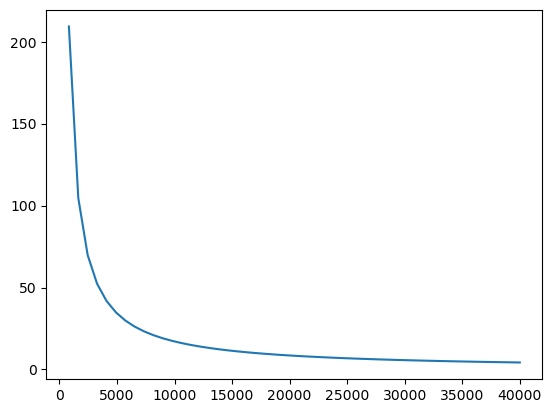

In [51]:
d = np.linspace(0,40000)
m = 1.0 #m_sun
f = 3.4e-3 # hz
amp = galactic_binary_Amp(m, f, d)
snr = analytic_snr(amp,f,0.5*YEAR)

plt.plot(d,snr)

In [17]:
"""
# Adapted from LISA.c


def AENoise(f):
    fonfstar = f/FSTAR
    trans = np.sin(fonfstar)**2
    return (16.0/3.0)*trans*( 
        (2.0+np.cos(fonfstar))*(SPS + SLOC) + 
        2.0*( 3.0 + 2.0*np.cos(fonfstar) + np.cos(2.0*fonfstar) ) * 
        ( SLOC/2.0 + SACC/((2*np.pi*f)**4)*rednoise(f) ) ) / ((2.0*LARM)**2)


def rednoise(f):
    return 1. + 16.0*(((2.0e-5/f)**10.0)+ ((1.0e-4/f)**2))

# A = Amplitude of GW
# Sn = noise power spectral density
# Sf = correction based on source proximity to transfer frequency
# sqT = sqrt(T) where T is the observation time
def analytic_snr(A, f, sqT):
    Sf = np.sin(f/FSTAR)
    Sn = AENoise(f)
    return 0.5*A*sqT*Sf/np.sqrt(Sn)

def amplitude_at_SNR(SNR, f, sqT):
    Sf = np.sin(f/FSTAR)
    Sn = AENoise(f)
    return SNR*np.sqrt(Sn)/(0.5*sqT*Sf)
"""


'\n# Adapted from LISA.c\n\n\ndef AENoise(f):\n    fonfstar = f/FSTAR\n    trans = np.sin(fonfstar)**2\n    return (16.0/3.0)*trans*( \n        (2.0+np.cos(fonfstar))*(SPS + SLOC) + \n        2.0*( 3.0 + 2.0*np.cos(fonfstar) + np.cos(2.0*fonfstar) ) * \n        ( SLOC/2.0 + SACC/((2*np.pi*f)**4)*rednoise(f) ) ) / ((2.0*LARM)**2)\n\n\ndef rednoise(f):\n    return 1. + 16.0*(((2.0e-5/f)**10.0)+ ((1.0e-4/f)**2))\n\n# A = Amplitude of GW\n# Sn = noise power spectral density\n# Sf = correction based on source proximity to transfer frequency\n# sqT = sqrt(T) where T is the observation time\ndef analytic_snr(A, f, sqT):\n    Sf = np.sin(f/FSTAR)\n    Sn = AENoise(f)\n    return 0.5*A*sqT*Sf/np.sqrt(Sn)\n\ndef amplitude_at_SNR(SNR, f, sqT):\n    Sf = np.sin(f/FSTAR)\n    Sn = AENoise(f)\n    return SNR*np.sqrt(Sn)/(0.5*sqT*Sf)\n'

In [2]:
import astropy.units as u
# adapted from https://github.com/eXtremeGravityInstitute/LISA_Sensitivity/blob/master/LISA.py

# Number of data channels
NC = 2
# Length of arm
Larm = 2.5e9
YEAR = u.yr.to(u.s)
# time of observation
Tobs = 4*YEAR

FSTAR = CLIGHT/(2.0*np.pi*Larm)

def Sn(f):
    """ Calculate the sensitivity curve """
    R = 3./20./(1. + 6./10.*(f/FSTAR)**2)*NC
        
    Sn = Pn(f)/R + SnC(f)

    return Sn


def Pn(f):
    """
    Caclulate the Strain Power Spectral Density
    """
    
    # single-link optical metrology noise (Hz^{-1}), Equation (10)
    P_oms = (1.5e-11)**2*(1. + (2.0e-3/f)**4) 
    
    # single test mass acceleration noise, Equation (11)
    P_acc = (3.0e-15)**2*(1. + (0.4e-3/f)**2)*(1. + (f/(8.0e-3))**4) 
    
    # total noise in Michelson-style LISA data channel, Equation (12)
    Pn = (P_oms + 2.*(1. + np.cos(f/FSTAR)**2)*P_acc/(2.*np.pi*f)**4)/Larm**2
    
    return Pn

#This looks like its GBnoise from Lisa.c
def SnC(f):
    # Fix the parameters of the confusion noise fit
    if (Tobs < .75*YEAR):
        est = 1
    elif (0.75*YEAR < Tobs and Tobs < 1.5*YEAR):
        est = 2
    elif (1.5*YEAR < Tobs and Tobs < 3.0*YEAR):   
        est = 3
    else:
        est = 4
            
    if (est==1):
        alpha  = 0.133
        beta   = 243.
        kappa  = 482.
        gamma  = 917.
        f_knee = 2.58e-3  
    elif (est==2):
        alpha  = 0.171
        beta   = 292.
        kappa  = 1020.
        gamma  = 1680.
        f_knee = 2.15e-3 
    elif (est==3):
        alpha  = 0.165
        beta   = 299.
        kappa  = 611.
        gamma  = 1340.
        f_knee = 1.73e-3  
    else:
        alpha  = 0.138
        beta   = -221.
        kappa  = 521.
        gamma  = 1680.
        f_knee = 1.13e-3 
    
    A = 1.8e-44/NC
    
    Sc  = 1. + np.tanh(gamma*(f_knee - f))
    Sc *= np.exp(-f**alpha + beta*f*np.sin(kappa*f))
    Sc *= A*f**(-7./3.)
    
    return Sc


5617.615152357805 s(1/2)


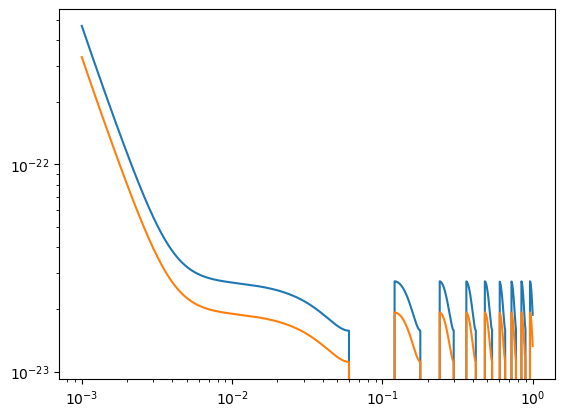

In [32]:
import astropy.units as u
sqT = np.sqrt((1*u.year).to(u.s))
print(sqT)

y = amplitude_at_SNR(10, x, sqT)
z = amplitude_at_SNR(10, x, sqT*np.sqrt(2))

fig, ax = plt.subplots(1,1)

ax.plot(x, y)
ax.plot(x, z)
ax.set_xscale('log')
ax.set_yscale('log')
